## Kaggle setup

In [ ]:
from google.colab import files
! pip install -q kaggle
files.upload()
! mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d bwandowando/2-million-formerly-twitter-google-reviews
! mkdir train
! unzip 2-million-formerly-twitter-google-reviews.zip -d train

Saving kaggle.json to kaggle.json
 95% 137M/144M [00:01<00:00, 133MB/s]
100% 144M/144M [00:01<00:00, 145MB/s]
Archive:  2-million-formerly-twitter-google-reviews.zip
  inflating: train/TWITTER_REVIEWS.csv  


## Imports

In [ ]:
%%capture
!pip install pandas==2.0.0
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import gc

# spacy for text preprocessing
import spacy
spacy.prefer_gpu()
from spacy.tokens import DocBin

# topic modeling using BERTopic
! pip install bertopic
from bertopic import BERTopic

# topic modeling using LDA and NMF
! pip install gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# visualization
! pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

import os

## Data Analysis

Let's load and preview the data

In [ ]:
df = pd.read_csv("./train/TWITTER_REVIEWS.csv",
                 usecols=["review_text", "review_rating", "review_likes", "author_app_version", "review_timestamp"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,review_text,review_rating,review_likes,author_app_version,review_timestamp
0,Not as good as HTC's Peep.,3,0,1.0.0,2010-04-30 21:21:48
1,Such a brilliant new Twitter app! Andy_mackie,5,0,1.0.0,2010-04-30 21:26:51
2,I dont see anything wrong with it,5,0,1.0.0,2010-04-30 21:29:21


Let's convert the timestamps to year and create a histogram to view the date distribution of tweets.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<BarContainer object of 14 artists>

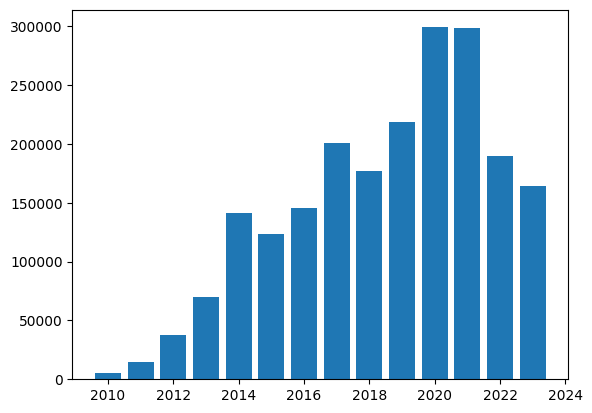

In [ ]:
df['year'] = pd.DatetimeIndex(df['review_timestamp']).year
counts = df['year'].value_counts().sort_index().to_numpy()
years = df['year'].unique()
plt.bar(years, counts)

There are most reviews in 2020 and 2021. 2010 ~ 2013 has few reviews compared to other years. The dataset contains reviews from 2010 ~ 2023.

For this project, we'll analyze and compare reviews from 2020 ~ 2023 with topic modeling techniques such as LDA and Bertopic.

First, let's separate the reviews.

In [ ]:
df_2020 = df.loc[(df['year'] == 2020)]
df_2021 = df.loc[(df['year'] == 2021)]
df_2022 = df.loc[(df['year'] == 2022)]
df_2023 = df.loc[(df['year'] == 2023)]
df_dict = {'df_2020': df_2020,
           'df_2021': df_2021,
           'df_2022': df_2022,
           'df_2023':df_2023}
dataframes = ['df_2020', 'df_2021', 'df_2022', 'df_2023']
print(f"Total number of reviews: 2020 - {df_2020.size}, 2021 - {df_2021.size}, 2022 - {df_2022.size}, 2023 - {df_2023.size}")

Total number of reviews: 2020 - 1794048, 2021 - 1790340, 2022 - 1136238, 2023 - 985350


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df = None
years = None
counts = None
gc.collect()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


238

### Define Functions for Preprocessing, EDA, and Topic Modeling

Function to filter out stop words and non alpha numeric words, and convert words to lemma form. We also filter out rows where the length of the processed review is less than or equal to 3 words in order to focus on longer reviews.

In [ ]:
def preprocess(dataframe, name):
  dataframe['pdoc'] = [[token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]
                        for doc in dataframe['doc']]
  dataframe.drop(columns='doc', inplace=True)
  original_size = len(dataframe.index)
  dataframe = dataframe.loc[dataframe['pdoc'].map(len) > 4]
  print(f"{len(dataframe.index)} processed reviews with length greater than two reduced from {original_size}")
  dataframe['doc_str'] = [" ".join(pdoc) for pdoc in dataframe['pdoc'].to_numpy()]
  dataframe.to_csv(f"./drive/MyDrive/twitter_review/{name}.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Function to perform EDA, displaying distribution of number of words per tweet, top words, distribution of review ratings, and average character and word count per tweet.

In [ ]:
def eda(dataframe):
  pdocs = dataframe['pdoc'].to_numpy()

  # Distribution of number of words per tweet
  length_counts = [len(review) for review in pdocs]
  char_counts = [sum([len(word) for word in review]) for review in pdocs]
  plt.hist(length_counts, bins=25)
  plt.title("Distribution of Length of Twitter Reviews")
  plt.xlabel("Count")
  plt.ylabel("Length")
  plt.show()

  # Top words
  all_words = [token for review in pdocs for token in review]
  word_count_dict = dict(Counter(all_words))
  popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
  plt.barh(range(25), [word_count_dict[w] for w in reversed(popular_words[0:25])])
  plt.yticks([x + 0.5 for x in range(25)], reversed(popular_words[0:25]))
  plt.title("Popular words")
  plt.xlabel("Count")
  plt.ylabel("Word")
  plt.show()

  # Number of positive and negative ratings based on rating value.
  ratings = dataframe['review_rating'].to_numpy()
  rating_count_dict = dict(Counter(ratings))
  plt.bar(rating_count_dict.keys(), rating_count_dict.values())
  plt.title("Distribution of review ratings")
  plt.xlabel("Rating")
  plt.ylabel("Count")
  plt.show()

  # Average character and word count per tweet.
  print(f'Average number of words per tweet after filtering {sum(length_counts)/len(length_counts)}')
  print(f'Average number of characters per tweet after filtering {sum(char_counts)/len(length_counts)}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Function for handling preprocessing and analyzing the dataset

In [ ]:
def analysis(name):
  if(os.path.isfile(f"./drive/MyDrive/twitter_review/{name}.csv")):
    df_dict[name] = pd.read_csv(f"./drive/MyDrive/twitter_review/{name}.csv")
    df_dict[name]['pdoc'] = [str(s).split() for s in df_dict[name]['doc_str'].to_numpy()]
    original_size = len(df_dict[name].index)
    df_dict[name] = df_dict[name].loc[df_dict[name]['pdoc'].map(len) > 4]
    print(f"{len(df_dict[name].index)} processed reviews with length greater than two reduced from {original_size}")
    eda(df_dict[name])
  else:
    doc_bin = DocBin(store_user_data=True)
    docs = []
    nlp = spacy.load("en_core_web_sm")
    for doc in nlp.pipe(df_dict[name]["review_text"].astype(str)):
      doc_bin.add(doc)

    df_dict[name]['doc'] = list(doc_bin.get_docs(nlp.vocab))
    preprocess(df_dict[name], name)
    eda(df_dict[name])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Function for performing LDA with Gensim

In [ ]:
def extractNGramAndCorpus(data):
  bigram = gensim.models.Phrases(data, min_count=5, threshold=100)
  trigram = gensim.models.Phrases(bigram[data], threshold=100)

  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)

  bigram_data = bigram_mod[data]
  trigram_data = trigram_mod[data]
  id2word = corpora.Dictionary(bigram_data)

  # Create Corpus
  texts = trigram_data

  # # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in data]
  return (trigram_data, corpus, id2word)

def performLDA(trigram_data, corpus, id2word, num_topics, name):
  if(os.path.isfile(f"./drive/MyDrive/twitter_review/{name}_lda_{num_topics}")):
    print(f"Load saved {name}_lda_{num_topics}")
    lda_model = gensim.models.ldamodel.LdaModel.load(f"./drive/MyDrive/twitter_review/{name}_lda_{num_topics}")
  else:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=20,
                                            alpha='auto',
                                            per_word_topics=True)
    lda_model.save(f"./drive/MyDrive/twitter_review/{name}_lda_{num_topics}")
  coherencemodel = CoherenceModel(model=lda_model, texts=trigram_data, dictionary=id2word, coherence='c_v')
  print(f"Coherence score of {num_topics} topics: {coherencemodel.get_coherence()}")
  return coherencemodel.get_coherence()

def selectBestLDA(data, name, limit, start=3, step=2):
  coherence_values = []
  models = []
  ngramAndCorpus = extractNGramAndCorpus(data)
  for num_topics in range(start, limit, step):
    coherence_values.append(performLDA(*ngramAndCorpus, num_topics, name))
    models.append(f"./drive/MyDrive/twitter_review/{name}_lda_{num_topics}")

  x = range(start, limit, step)
  plt.plot(x, coherence_values)
  plt.xlabel("Num Topics")
  plt.ylabel("Coherence score")
  plt.legend(("coherence_values"), loc='best')
  plt.show()

  best_model = gensim.models.ldamodel.LdaModel.load(models[np.argmax(coherence_values)])
  # pyLDAvis.enable_notebook()
  # vis = pyLDAvis.gensim_models.prepare(best_model, ngramAndCorpus[1], ngramAndCorpus[2])
  topics = best_model.print_topics()
  for t in topics:
    print(t)
  # display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Function for Topic Modeling using Bertopic

In [ ]:
def performBertopic(data, name):
  print(f"./drive/MyDrive/twitter_review/{name}")
  if(os.path.isdir(f"./drive/MyDrive/twitter_review/{name}")):
    print("Load saved bertopic model")
    topic_model = BERTopic.load(f"./drive/MyDrive/twitter_review/{name}")
  else:
    vectorizer_model = CountVectorizer()
    topic_model = BERTopic(low_memory=True, verbose=True, vectorizer_model=vectorizer_model, embedding_model="all-MiniLM-L6-v2",)
    topics, probs = topic_model.fit_transform(data)
    topic_model.save(f"./drive/MyDrive/twitter_review/{name}", serialization="pytorch")
  display(topic_model.visualize_barchart())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Processing & Topic Modeling

#### 2020

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



53455 processed reviews with length greater than two reduced from 267112


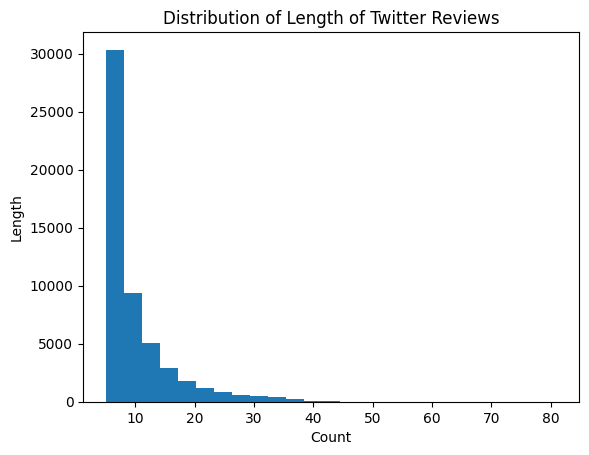

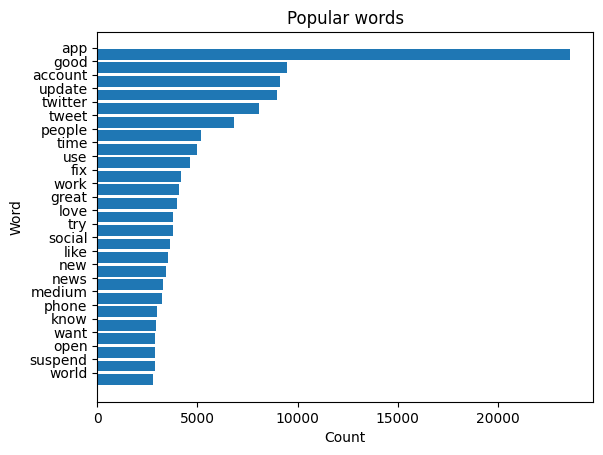

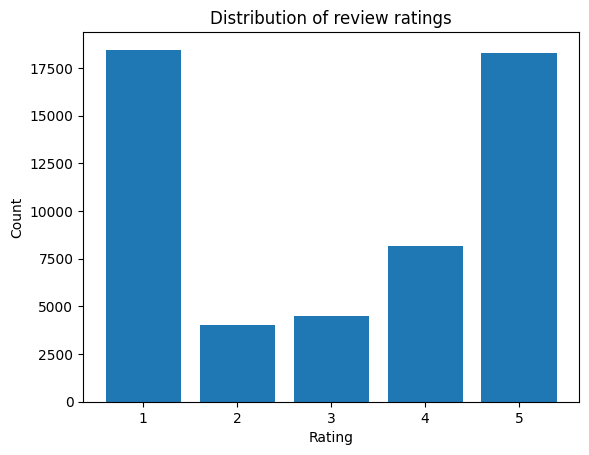

Average number of words per tweet after filtering 9.962360864278365
Average number of characters per tweet after filtering 54.62991301094378


In [ ]:
df_name = 'df_2020'
analysis(df_name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Load saved df_2020_lda_3
Coherence score of 3 topics: 0.4392839651263368
Load saved df_2020_lda_5
Coherence score of 5 topics: 0.36791653615193987
Load saved df_2020_lda_7
Coherence score of 7 topics: 0.3330248702741271
Load saved df_2020_lda_9
Coherence score of 9 topics: 0.3006166833512024


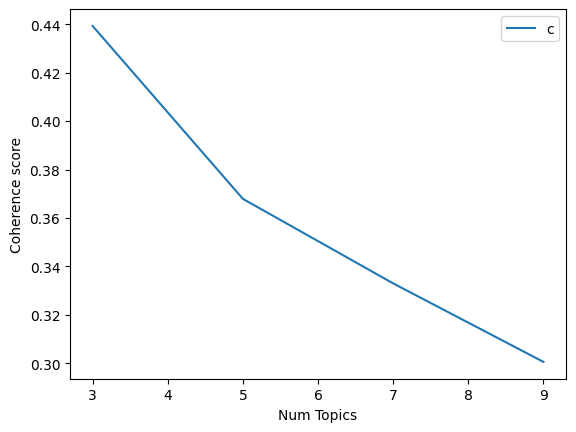

(0, '0.054*"account" + 0.028*"twitter" + 0.025*"time" + 0.023*"try" + 0.016*"suspend" + 0.015*"number" + 0.015*"bad" + 0.013*"say" + 0.012*"phone" + 0.012*"log"')
(1, '0.097*"app" + 0.037*"good" + 0.025*"people" + 0.023*"use" + 0.017*"great" + 0.016*"social" + 0.016*"like" + 0.016*"love" + 0.014*"twitter" + 0.013*"medium"')
(2, '0.045*"tweet" + 0.040*"update" + 0.027*"work" + 0.025*"fix" + 0.024*"new" + 0.021*"need" + 0.017*"fleet" + 0.016*"problem" + 0.015*"star" + 0.014*"option"')


In [ ]:
selectBestLDA(df_dict[df_name]['pdoc'].to_numpy(), df_name, 10)

In [ ]:
performBertopic([" ".join(doc) for doc in df_dict[df_name]['pdoc'].to_numpy()], f'{df_name}_bert')

./drive/MyDrive/twitter_review/df_2020_bert
Load saved bertopic model


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
df_dict[df_name] = None
gc.collect()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



15749

#### 2021

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



62427 processed reviews with length greater than two reduced from 265162


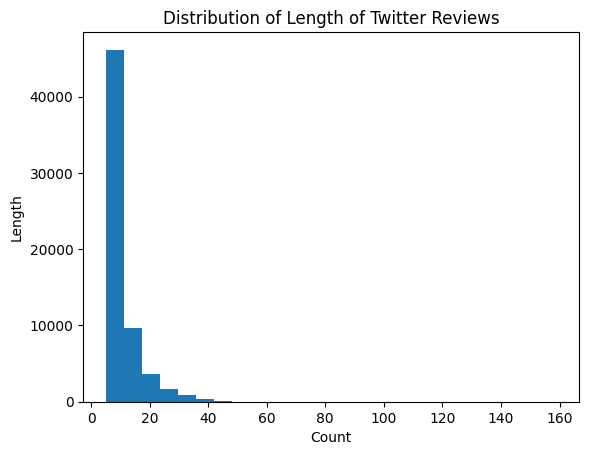

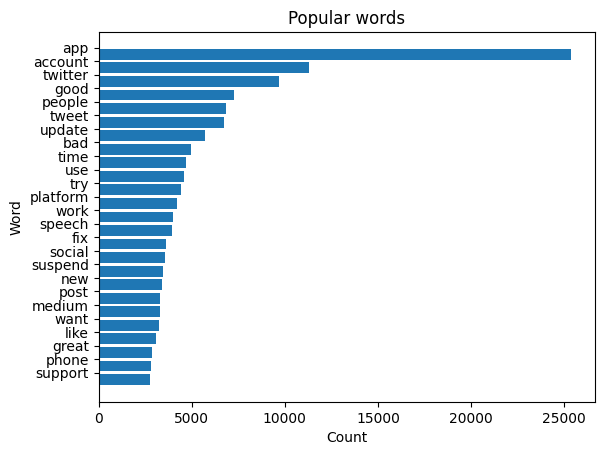

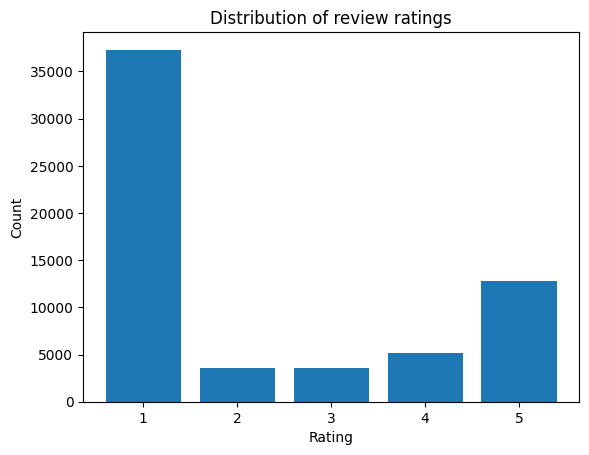

Average number of words per tweet after filtering 9.964326333157128
Average number of characters per tweet after filtering 55.75122943598122


In [ ]:
df_name = 'df_2021'
analysis(df_name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Load saved df_2021_lda_3
Coherence score of 3 topics: 0.4532874476070828
Load saved df_2021_lda_5
Coherence score of 5 topics: 0.40848967641548767
Load saved df_2021_lda_7
Coherence score of 7 topics: 0.3630239198759278
Load saved df_2021_lda_9
Coherence score of 9 topics: 0.3223464190100883


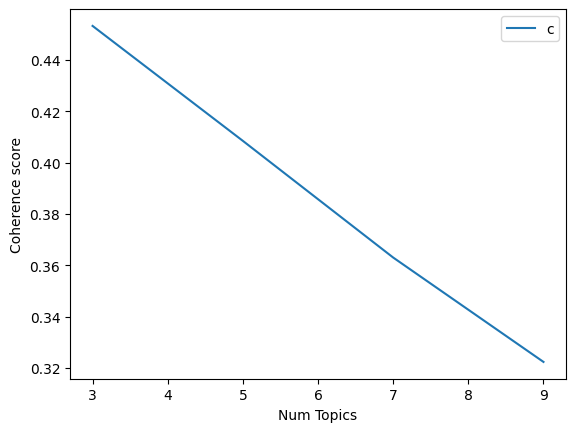

(0, '0.075*"app" + 0.034*"good" + 0.020*"use" + 0.019*"people" + 0.015*"like" + 0.015*"bad" + 0.014*"love" + 0.012*"social" + 0.011*"medium" + 0.011*"great"')
(1, '0.038*"account" + 0.032*"tweet" + 0.029*"update" + 0.019*"time" + 0.019*"fix" + 0.018*"app" + 0.017*"twitter" + 0.015*"try" + 0.014*"work" + 0.014*"new"')
(2, '0.023*"claim" + 0.017*"hate" + 0.015*"fake" + 0.014*"people" + 0.014*"ban" + 0.013*"allow" + 0.012*"right" + 0.012*"support" + 0.011*"platform" + 0.011*"view"')


In [ ]:
selectBestLDA(df_dict[df_name]['pdoc'].to_numpy(), df_name, 10)

In [ ]:
performBertopic([" ".join(doc) for doc in df_dict[df_name]['pdoc'].to_numpy()], f'{df_name}_bert')

./drive/MyDrive/twitter_review/df_2021_bert
Load saved bertopic model


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
df_dict[df_name] = None
gc.collect()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



12803

#### 2022

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



47866 processed reviews with length greater than two reduced from 170858


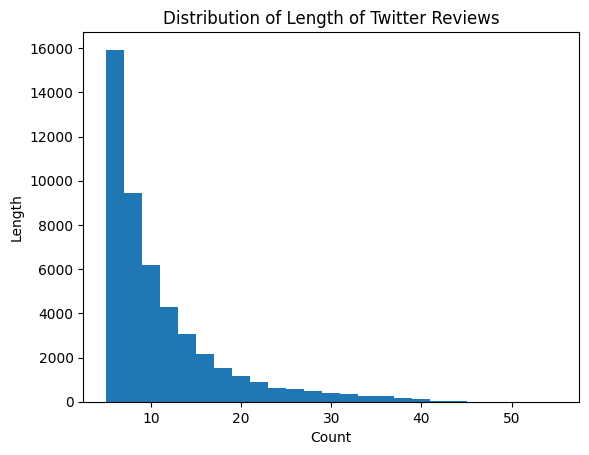

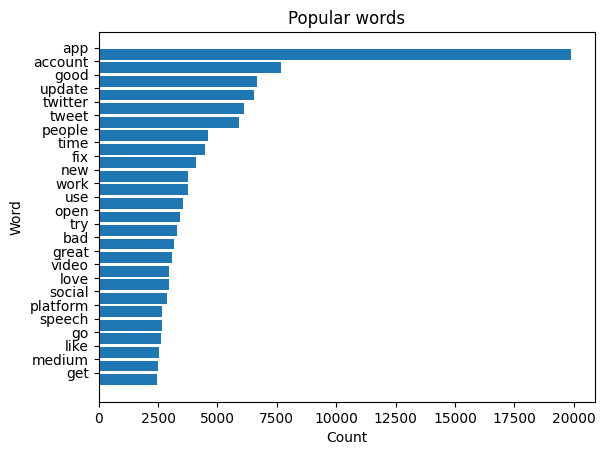

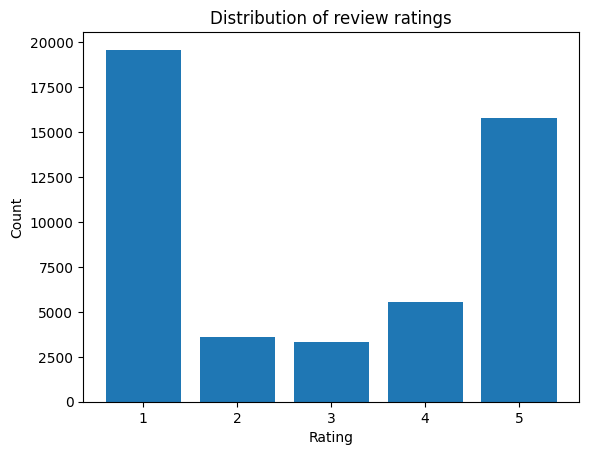

Average number of words per tweet after filtering 10.504136547862784
Average number of characters per tweet after filtering 57.6760330923829


In [ ]:
df_name = 'df_2022'
analysis(df_name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Load saved df_2022_lda_3
Coherence score of 3 topics: 0.4212596817692285
Load saved df_2022_lda_5
Coherence score of 5 topics: 0.3575394887612946
Load saved df_2022_lda_7
Coherence score of 7 topics: 0.34901095869933263
Load saved df_2022_lda_9
Coherence score of 9 topics: 0.3407107621973803


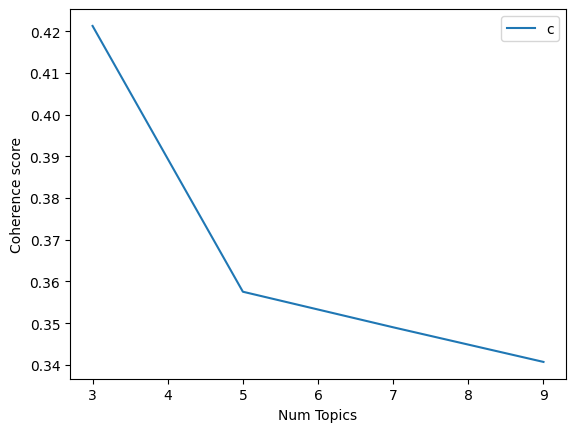

(0, '0.073*"account" + 0.040*"speech" + 0.026*"free" + 0.020*"suspend" + 0.019*"freedom" + 0.014*"support" + 0.013*"login" + 0.013*"hate" + 0.012*"ban" + 0.012*"right"')
(1, '0.035*"tweet" + 0.028*"update" + 0.024*"try" + 0.024*"time" + 0.020*"take" + 0.019*"work" + 0.019*"get" + 0.016*"new" + 0.016*"post" + 0.015*"bad"')
(2, '0.077*"app" + 0.027*"good" + 0.021*"twitter" + 0.018*"number" + 0.017*"well" + 0.017*"people" + 0.015*"great" + 0.015*"phone" + 0.014*"use" + 0.013*"thank"')


In [ ]:
selectBestLDA(df_dict[df_name]['pdoc'].to_numpy(), df_name, 10)

In [ ]:
performBertopic([" ".join(doc) for doc in df_dict[df_name]['pdoc'].to_numpy()], f'{df_name}_bert')

./drive/MyDrive/twitter_review/df_2022_bert
Load saved bertopic model


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
df_dict[df_name] = None
gc.collect()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



1140

#### 2023

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



49186 processed reviews with length greater than two reduced from 49186


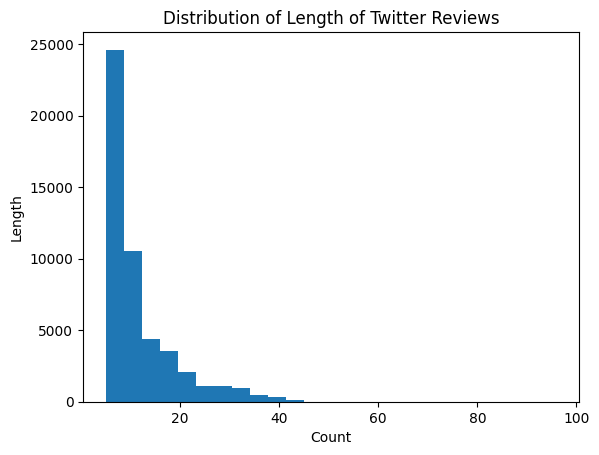

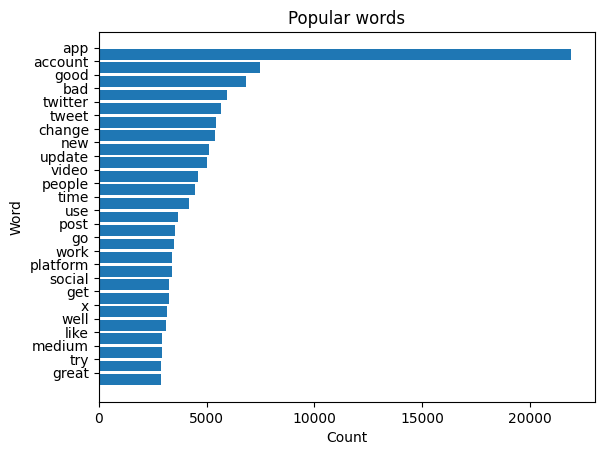

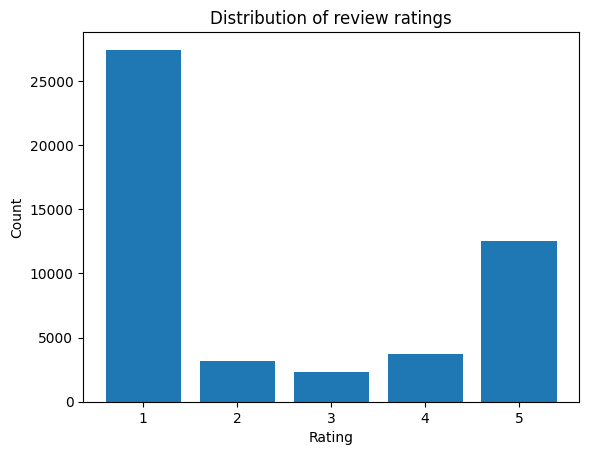

Average number of words per tweet after filtering 11.222847964868052
Average number of characters per tweet after filtering 61.233338754930266


In [ ]:
df_name = 'df_2023'
analysis(df_name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Load saved df_2023_lda_3
Coherence score of 3 topics: 0.39476898534367116
Load saved df_2023_lda_5
Coherence score of 5 topics: 0.4438565490786875
Load saved df_2023_lda_7
Coherence score of 7 topics: 0.46005352596337046
Load saved df_2023_lda_9


/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.10/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning:

invalid value encountered in double_scalars



Coherence score of 9 topics: nan


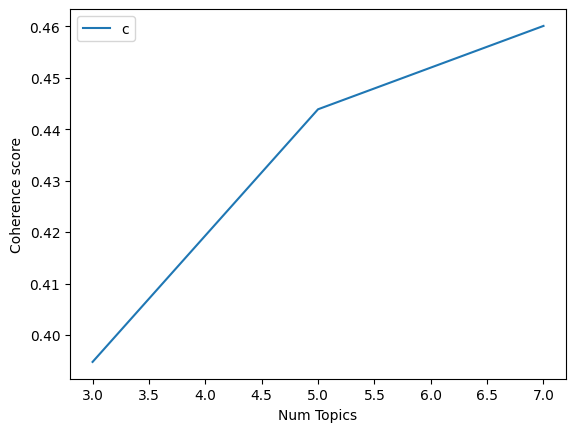

(0, '0.093*"account" + 0.087*"bad" + 0.059*"time" + 0.037*"try" + 0.034*"want" + 0.024*"user" + 0.023*"problem" + 0.022*"phone" + 0.020*"say" + 0.019*"hate"')
(1, '0.103*"video" + 0.102*"nice" + 0.071*"twitter" + 0.055*"get" + 0.039*"need" + 0.035*"know" + 0.031*"play" + 0.024*"number" + 0.021*"elon" + 0.019*"block"')
(2, '0.263*"app" + 0.190*"good" + 0.055*"great" + 0.050*"x" + 0.050*"love" + 0.033*"work" + 0.021*"excellent" + 0.013*"musk" + 0.012*"follow" + 0.010*"far"')
(3, '0.074*"take" + 0.057*"suspend" + 0.054*"star" + 0.045*"awesome" + 0.041*"amazing" + 0.029*"come" + 0.028*"enjoy" + 0.027*"send" + 0.027*"ad" + 0.024*"informative"')
(4, '0.064*"social" + 0.058*"medium" + 0.055*"people" + 0.029*"thing" + 0.027*"content" + 0.027*"opinion" + 0.026*"world" + 0.024*"truth" + 0.022*"feature" + 0.022*"allow"')
(5, '0.154*"well" + 0.137*"thank" + 0.031*"lot" + 0.026*"able" + 0.026*"bias" + 0.020*"download" + 0.020*"wonderful" + 0.018*"reply" + 0.018*"start" + 0.018*"fair"')
(6, '0.113*"

In [ ]:
selectBestLDA(df_dict[df_name]['pdoc'].to_numpy(), df_name, 10)

In [ ]:
performBertopic([" ".join(doc) for doc in df_dict[df_name]['pdoc'].to_numpy()], f'{df_name}_bert')

./drive/MyDrive/twitter_review/df_2023_bert
Load saved bertopic model


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
df_dict[df_name] = None
gc.collect()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



18868

# References

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://hackernoon.com/nlp-tutorial-topic-modeling-in-python-with-bertopic-372w35l9